In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

In [95]:
# Création d'un jeu de données personnalisé
from classes import VideosDataset

In [96]:
image_dir = 'train/images'
annotation_dir = 'train/labels'

annotations = []
for filename in os.listdir(annotation_dir):
    if filename.endswith('.csv'):
        filepath = os.path.join(annotation_dir, filename)
        try:
            df = pd.read_csv(filepath, header=None)
            if not df.empty:
                annotations.extend(df.iloc[:, 4].values)
        except Exception as e:
            pass

label_encoder = LabelEncoder()
label_encoder.fit(annotations)

LabelEncoder()

In [97]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = VideosDataset(image_dir='train/images',
                              annotation_dir='train/labels',
                              label_encoder=label_encoder,
                              transform=transform)

val_dataset = VideosDataset(image_dir='val/images',
                            annotation_dir='val/labels',
                            label_encoder=label_encoder,
                            transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [98]:
# Définition du modèle
from classes import SimpleCNN

num_classes = len(label_encoder.classes_)
model = SimpleCNN(num_classes)

In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [102]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch+1}/{num_epochs}')
    model.train()
    running_loss = 0.0
    i = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f'Batch {i+1}/{len(train_loader)} done. Loss: {loss.item()}')
        i += 1

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%')

Starting Epoch 1/10
Batch 1/22 done. Loss: 0.18845345079898834
Batch 2/22 done. Loss: 0.3029358685016632
Batch 3/22 done. Loss: 0.22564789652824402
Batch 4/22 done. Loss: 0.5592700242996216
Batch 5/22 done. Loss: 0.2784807085990906
Batch 6/22 done. Loss: 0.3785087466239929
Batch 7/22 done. Loss: 0.45788833498954773
Batch 8/22 done. Loss: 0.37849926948547363
Batch 9/22 done. Loss: 0.3266777992248535
Batch 10/22 done. Loss: 0.4210430085659027
Batch 11/22 done. Loss: 0.493418425321579
Batch 12/22 done. Loss: 0.7023091912269592
Batch 13/22 done. Loss: 0.31748732924461365
Batch 14/22 done. Loss: 0.32031363248825073
Batch 15/22 done. Loss: 0.6541659235954285
Batch 16/22 done. Loss: 0.3038550615310669
Batch 17/22 done. Loss: 0.31514400243759155
Batch 18/22 done. Loss: 0.22762708365917206
Batch 19/22 done. Loss: 0.21437948942184448
Batch 20/22 done. Loss: 0.916152834892273
Batch 21/22 done. Loss: 0.31190264225006104
Batch 22/22 done. Loss: 0.28668999671936035
Epoch [1/10], Loss: 0.390038669109

In [103]:
 # Évaluation finale sur le jeu de validation
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Validation Loss: {val_loss/len(val_loader)}, Final Accuracy: {100 * correct / total}%')

Error reading 0179.csv: No columns to parse from file
Error reading 0342.csv: No columns to parse from file
Error reading 0745.csv: No columns to parse from file
Error reading 0442.csv: No columns to parse from file
Error reading 0733.csv: No columns to parse from file
Final Validation Loss: 0.12468917295336723, Final Accuracy: 95.40229885057471%


In [104]:
import pickle
with open('simple_cnn.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
with open('cnn_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

In [105]:
# detection
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

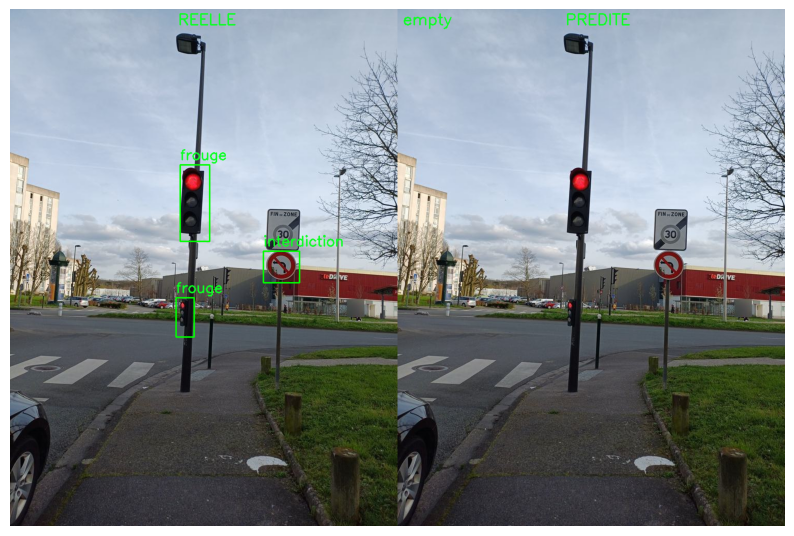

In [106]:
def detect_objects(image_path, model, label_encoder):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = transform(image).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        label = label_encoder.inverse_transform(predicted.numpy())[0]
    return label

def draw_boxes(image_path, annotation_path):
    image = cv2.imread(image_path)
    annotation = pd.read_csv(annotation_path, header=None)
    for i in range(len(annotation)):
        label = annotation.iloc[i, 4]
        if label != 'empty':
            x1 = int(annotation.iloc[i, 0])
            y1 = int(annotation.iloc[i, 1])
            x2 = int(annotation.iloc[i, 2])
            y2 = int(annotation.iloc[i, 3])
        else:
            x1, y1, x2, y2 = 10, 40, 0, 0
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        cv2.putText(image, 'REELLE', (image.shape[1]//2-50, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (36,255,12), 2)
    return image

def draw_boxes_pred(image_path, model, label_encoder):
    image = cv2.imread(image_path)
    label = detect_objects(image_path, model, label_encoder)
    cv2.putText(image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (36,255,12), 2)
    cv2.putText(image, 'PREDITE', (image.shape[1]//2-50, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (36,255,12), 2)
    return image

def display_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

image_path = 'train/images/0017.jpg'
annotation_path = 'train/labels/0017.csv'

image = draw_boxes(image_path, annotation_path)
image_pred = draw_boxes_pred(image_path, model, label_encoder)
display_image(np.hstack((image, image_pred)))